In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

In this we will look at Arxiv papers published in ML and AI since the year 2015- with focus of Co-Author Network.We will use Deep Walk (which is a concept based of Word Embeddings) to cluster author networks.
This kind of embedding a Graph, can help in applications like clustering, Link PRediction etc.

For Visualising the Graph we will use pyvis

In [2]:
! pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 17.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.9 MB/s eta 0:00:00


# Load the Libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import sys
import ast

import plotly.express as px

#import nltk
#from nltk.corpus import stopwords
#import spacy

import matplotlib.pyplot as plt
import seaborn as sns



import networkx as nx
from networkx.algorithms.components.connected import connected_components

import json
import dask.bag as db

import sys
import os

sys.path.append("..")

from pathlib import Path

import json


from itertools import combinations
from collections import Counter
from itertools import chain
import random

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

import multiprocessing
import smart_open

from gensim.models.word2vec import Word2Vec

from pyvis.network import Network

from IPython.core.display import display, HTML

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

/var/folders/hn/p77x1w5x5s725x1wyvhfn59h0000gn/T/ipykernel_6409/888553813.py:49: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Extract the Data from Kaggle

In [4]:
# Extract Only the AI , ML PAPERS
def extractArxivData(categories=['stat.ML','cs.AI'],year=None,raw_data_path="../data/raw/",save_extracted_filename="../data/processed/AI_ML.json"):
    """ This function extracts data for the given set of categories and save the data into the save_extracted_filename path """
    records=db.read_text(raw_data_path+"/*.json").map(lambda x:json.loads(x))
    docs = (records.filter(lambda x:any(ele in x['categories'] for ele in categories)==True))
    extract_latest_version=lambda x:x['versions'][-1]["created"]
    if year!=None:
        docs=docs.filter(lambda x:int(extract_latest_version(x).split(" ")[3])>=year)

    get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}

    data=docs.map(get_metadata).to_dataframe().compute()

    ## Creating authors fields by joining first and last nmes in authors_parsed columns.
    data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])

    print("Number of Records Extracted for Given Set of Categories ",data.shape[0])
    Path(os.path.dirname(save_extracted_filename)).mkdir(parents=True, exist_ok=True)
    data.to_json(save_extracted_filename,orient="records")
    return data


In [8]:
RAW_DATA_PATH="."


In [9]:
## Collect data for Papers published in ['stat.ML','cs.AI'] since year 2015.
data=extractArxivData(categories=['stat.ML','cs.AI'],year=2015,raw_data_path=RAW_DATA_PATH,save_extracted_filename="AI_ML_since2015.json")

Number of Records Extracted for Given Set of Categories  127725


# Creating a Co-Author Network

For the set of papers extracted, for every pair of authors an edge is to be created. The Edge weight will be the number of papers the two authors have collabrated on.

## Load the Data


In [10]:
data['author_pairs']=data['authors'].apply(lambda x:list(combinations(x, 2)))
data.head()

,id,title,category,abstract,version,doi,authors_parsed,authors,author_pairs
0,0709.1667,Solving Constraint Satisfaction Problems throu...,cs.AI cond-mat.dis-nn cond-mat.stat-mech cs.CC,Message passing algorithms have proved surpr...,"Tue, 4 Jun 2019 11:43:45 GMT",None,"[[Montanari, Andrea, ], [Ricci-Tersenghi, Fede...","[Montanari Andrea, Ricci-Tersenghi Federico, S...","[(Montanari Andrea, Ricci-Tersenghi Federico),..."
1,0811.2551,Modeling Cultural Dynamics,cs.MA cs.AI q-bio.NC,EVOC (for EVOlution of Culture) is a compute...,"Tue, 9 Jul 2019 20:25:22 GMT",None,"[[Gabora, Liane, ]]",[Gabora Liane],[]
2,0812.0885,Elementary epistemological features of machine...,cs.AI,Theoretical analysis of machine intelligence...,"Fri, 30 Jun 2017 14:10:03 GMT",None,"[[Horvat, Marko, ]]",[Horvat Marko],[]
3,0812.4044,The Offset Tree for Learning with Partial Labels,cs.LG cs.AI,"We present an algorithm, called the Offset T...","Sun, 3 Apr 2016 21:41:38 GMT",None,"[[Beygelzimer, Alina, ], [Langford, John, ]]","[Beygelzimer Alina, Langford John]","[(Beygelzimer Alina, Langford John)]"
4,0902.3430,Domain Adaptation: Learning Bounds and Algorithms,cs.LG cs.AI,This paper addresses the general problem of ...,"Thu, 30 Nov 2023 22:47:15 GMT",None,"[[Mansour, Yishay, ], [Mohri, Mehryar, ], [Ros...","[Mansour Yishay, Mohri Mehryar, Rostamizadeh A...","[(Mansour Yishay, Mohri Mehryar), (Mansour Yis..."


## For our Analysis, we will consider authors who have published papers after 2015 and published more than 2 papers.


In [11]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list


In [12]:
ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(192879, 2)

In [13]:
papers_by_authors['Number of Papers Published'].describe()


count    192879.000000
mean          2.713541
std           5.464295
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         297.000000
Name: Number of Papers Published, dtype: float64

In [14]:
## Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>2,'authors'].tolist()
len(nodes_to_keep)

45273

### Generating the Edges of the Co-Author Network

In [15]:

authors_pairs=data['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Montanari Andrea', 'Ricci-Tersenghi Federico', 2),
 ('Montanari Andrea', 'Semerjian Guilhem', 1),
 ('Ricci-Tersenghi Federico', 'Semerjian Guilhem', 1),
 ('Beygelzimer Alina', 'Langford John', 3),
 ('Mansour Yishay', 'Mohri Mehryar', 6),
 ('Mansour Yishay', 'Rostamizadeh Afshin', 1),
 ('Mohri Mehryar', 'Rostamizadeh Afshin', 2),
 ('Kuznetsov Sergei O.', 'Ignatov Dmitry I.', 1),
 ('Blume Lawrence', 'Easley David', 1),
 ('Blume Lawrence', 'Halpern Joseph Y.', 1)]

### Creating the Graph on the Complete Data

In [16]:
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

190398


### Filtering the Graph, to keep nodes (authors) who have atleast published 3 papers. We will also remove any isolated nodes in the generated network

In [17]:
## From the complete Graph, create a subgraph, with only the nodes to keep
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

45163


636

In [18]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)

44527

In [19]:
del G1, sub_g

In [20]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  44527
Number of Edges in AUthor Graph  458103


## Implementing Deep Walk

**Deep walk uses the concept of Random Walks to assign an embedding to each node in the network.**

1. In Random Walk, given a node we pick one of its neighbours at random and move to this node and from this node again choose another node among its neighbours at random. This continues for a fixed number of steps.



2. Once we have random walks generated for every node in the network, in DeepWalk the next step is to predict probability of visiting node "v" on a random walk starting from node "u".

3. This is very similar to the Skip-Gram model used in Word2Vec Model in NLP, wherein we try to predict the neighbouring words given a particular target word.


### Define Function for Random Walk


In [21]:
def getRandomWalk(graph,node,length_of_random_walk):
    """ This function takes NetworkX Graph and a Node and generate random walk for a given length

    Returns the random walk (list of nodes traversed)

    Note: The same node may occcur more than once in a Random Walk.
    """
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        ## Choose a random neighbour of the current node

        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk




In [22]:
### For every Node in the Graph, get randomwalks . For eahc node, let us get random walks say around 10 times each of path length 10
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):

    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))




Iterating Nodes:   0%|          | 0/44527 [00:00<?, ?it/s]

The data now is similar to list of words in a sentence and we can use gensim to create Node Embedding Model - here each author is a Node and Node is similar to word in a sentence

In [23]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,
                        vector_size=128,epochs=20,compute_loss=True)

In [24]:
deepwalk_model.save("deepwalk_since2015.model")

## Lets Look who are similar authors

In [25]:
def getSimilarNodes(model,node):
    """
    This function takes deepwalk model and a node

    Returns the top 10 nodes (author) similar to the given node
    """
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes



In [26]:
%%time
getSimilarNodes(deepwalk_model,"Bengio Yoshua")

CPU times: user 28.1 ms, sys: 3.2 ms, total: 31.3 ms
Wall time: 16 ms


,Similar_Node,Similarity_Score,Source_Node
0,Jo Jason,0.739033,Bengio Yoshua
1,Perreault-Levasseur Laurence,0.703841,Bengio Yoshua
2,Ernoult Maxence,0.689614,Bengio Yoshua
3,Grollier Julie,0.682731,Bengio Yoshua
4,Alsing Justin,0.674982,Bengio Yoshua
5,Hezaveh Yashar,0.664082,Bengio Yoshua
6,Smofsky Ariella,0.662390,Bengio Yoshua
7,Nakamura Keigo,0.659499,Bengio Yoshua
8,Hirtzlin Tifenn,0.655288,Bengio Yoshua
9,Kochmar Ekaterina,0.648047,Bengio Yoshua


The top 3 similar authors have recently published a paper **Scaling Equilibrium Propagation to Deep ConvNets by Drastically Reducing its Gradient Estimator Bias**. They have published lot of work together in the recent years.

Jo Jason since 2019 has published 7 papers with Yoshua


### Let us look at the CoAuthorship Network of the top popular Authors



In [27]:
ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors

,authors,Number of Papers Published
95905,Liu Yang,297
89082,Levine Sergey,292
12790,Bengio Yoshua,291
217,Abbeel Pieter,234
141882,Schölkopf Bernhard,211
...,...,...
78930,Kim Kyung-Jun,1
78928,Kim Kyung Geun,1
78927,Kim Kyung,1
78925,Kim Kyu Seok,1


Lets get the graph of these top  Authors with their first step neighbours.We consider the authors ranked 4th to 10th to help visualise the clusters better

In [28]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    """
    This function takes a Graph and list of initial nodes

    Returns the set of immediate neighbours of these nodes

    """
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)

        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))



In [29]:

coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['authors'].tolist()[4:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

2176
Number of CoAuthor Nodes  2082


### Generate a Co-Author Graph from the complete Graph

In [30]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  28719


In [31]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Author4to10.gexf")

In [32]:
#coauthor_subgraph=nx.read_gexf("CoAuthor_Subgraph_Top50Author.gexf")
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  28719


### Visualise the generated network

In [33]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Author4to10_CoAuthorGraph.html")



Creating PyVis from NetworkX
Saving PyVis Graph
Author4to10_CoAuthorGraph.html


We can see some clusters already. Lets see if embeddings is able to seperate these clusters
### Cluster the Nodes - based on Embeddings

Idea is to see if similar nodes belong to the same cluster.

In [34]:
def getCosineDistanceMatrix(vectors):
    '''
    This function takes list of vectors or numpy array

    Returns the pairwise cosine similarity matrix
    '''
    if type(vectors)==list:
        X=np.asarray(vectors)
    elif type(vectors)==np.ndarray:
        X=vectors
    else:
        print("Error in Data Type . Need to Pass list or numpy array as input argument")
        return []
    cosine_dist=cosine_distances(X)
    return cosine_dist


In [35]:
coauthor_nodes=list(coauthor_subgraph.nodes)
print("Number of CoAuthor Subgraph Nodes",len(coauthor_nodes))

Number of CoAuthor Subgraph Nodes 2082


In [36]:
coauthor_embeddings=[deepwalk_model.wv[node] for node in coauthor_nodes]

In [37]:
coauthor_embeddings=np.asarray(coauthor_embeddings)

print(coauthor_embeddings.shape)

(2082, 128)


In [38]:
cosine_dist=getCosineDistanceMatrix(coauthor_embeddings)


### APply K-Means tp select the optimal number of clusters

In [39]:
sse=[]
k_list=[]
for k in range(2,20):

    km=KMeans(n_clusters=k)
    km.fit(cosine_dist)
    sse.append(km.inertia_)




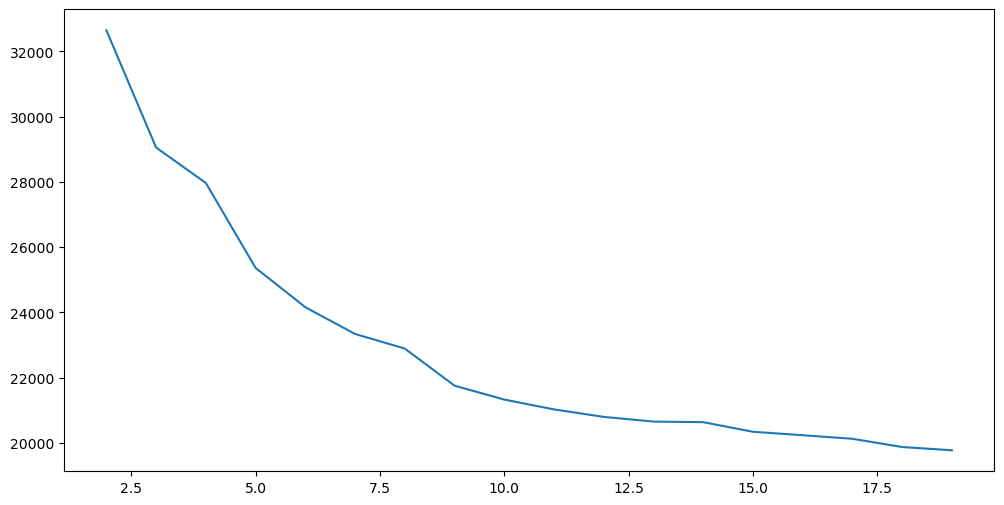

In [40]:
plt.figure(figsize=(12,6))
plt.plot([i for i in range(2,20)],sse)


Lets pick 7 clusters and update Node Attribute of the coAuthor Subgraph

In [41]:
km=KMeans(n_clusters=7)
coauthor_clusters=km.fit_predict(cosine_dist)
coauthor_cluster_dict={node:str(coauthor_clusters[idx]) for idx,node in enumerate(coauthor_nodes)}
nx.set_node_attributes(coauthor_subgraph,coauthor_cluster_dict,"group")

In [42]:
pyvis_nt=Network(notebook=True,height='600px', width='100%',heading='Author Network')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)
pyvis_nt.toggle_physics(True)
print("Saving PyVis Graph")
#pyvis_nt.show_buttons()
#pyvis_nt.set_options('var options = {"edges": { "color": { "inherit": true },"smooth": false},"physics": {"hierarchicalRepulsion": { "centralGravity": 0 },"minVelocity": 0.75, "solver": "hierarchicalRepulsion","timestep": 0.18}}')


pyvis_nt.show("Author4to10_CoAuthorGraph_Clustered.html")


Creating PyVis from NetworkX
Saving PyVis Graph
Author4to10_CoAuthorGraph_Clustered.html


We can see that the embeddings has done a pretty good job at clustering the network.

### Visualising Bengio Yoshuas Network

In [43]:
bengio_nodes=getCoAuthorshipNetwork(G,['Bengio Yoshua'])
bengio_network=nx.subgraph(G,bengio_nodes)
print("Number of Nodes in Bengio Network ",len(bengio_network.nodes()))
print("Number of Edges in Bengio Network ",len(bengio_network.edges()))

530
Number of Nodes in Bengio Network  531
Number of Edges in Bengio Network  4048


In [44]:
bengio_nt=Network(notebook=True,height='800px', width='100%',heading='Bengio Network')

print("Creating PyVis from NetworkX")
bengio_nt.from_nx(bengio_network)
bengio_nt.toggle_physics(True)
#bengio_nt.enable_physics(True)
print("Saving PyVis Graph")

bengio_nt.show_buttons()
bengio_nt.show("Bengio_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph
Bengio_CoAuthorGraph.html
